In [ ]:
!git clone https://github.com/spbstu-study/video-object-segmentation

## Подключаем необходимые модули

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage import measure
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.morphology import dilation, disk
from skimage.draw import polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.18.0
GPU is ON


## Подготовим набор данных для обучения

In [ ]:
CLASSES = 8
COLORS = ['black', 'red', 'lime',
          'blue', 'orange', 'pink',
          'cyan', 'magenta']
SAMPLE_SIZE = (256, 256)
OUTPUT_SIZE = (1080, 1920)

In [ ]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0

    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, OUTPUT_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    masks = []

    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))

    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks

def augmentate_images(image, masks):
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)

    random_flip = tf.random.uniform((), 0, 1)
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)

    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)

    return image, masks

In [ ]:
images = sorted(glob.glob('video-object-segmentation/neural_network/images/default_objects/img/*.jpg'))
masks = sorted(glob.glob('video-object-segmentation/neural_network/images/default_objects/masks_machine/*.png'))

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(60)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

## Посмотрим на содержимое набора данных

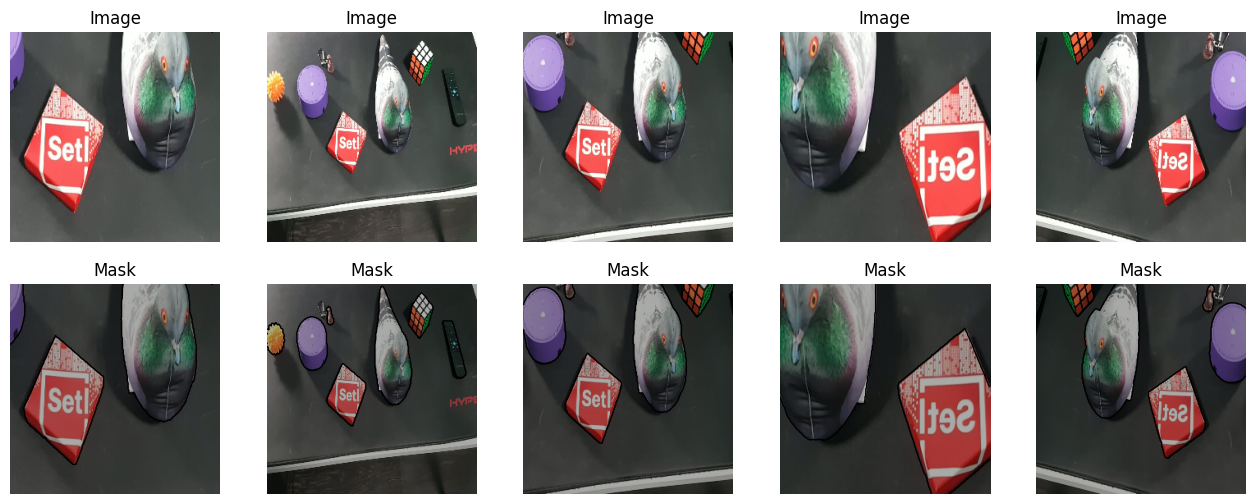

In [ ]:
images_and_masks = list(dataset.take(5))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(16, 6))

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)

    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()
    ax[1, i].imshow(image/1.5)

    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

## Разделим набор данных на обучающий и проверочный

In [ ]:
train_dataset = dataset.take(2000).cache()
test_dataset = dataset.skip(2000).take(100).cache()

train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

## Определим метрики и функции потерь

In [ ]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)

    dice_summ = 0

    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator

    avg_dice = dice_summ / CLASSES

    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

## Обозначим основные блоки модели


In [ ]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()

    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()

    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))

    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')


## Построим U-NET подобную архитектуру

In [ ]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)

downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

## Компилируем модель

In [ ]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

## Обучаем нейронную сеть и сохраняем результат

In [ ]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=25, initial_epoch=0)

Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 806s 3s/step - dice_mc_metric: 0.1063 - loss: 0.4009 - val_dice_mc_metric: 0.1058 - val_loss: 0.3384
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - dice_mc_metric: 0.4130 - loss: 0.1905 - val_dice_mc_metric: 0.9553 - val_loss: 0.1653
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 130ms/step - dice_mc_metric: 0.9959 - loss: 0.0101 - val_dice_mc_metric: 0.9951 - val_loss: 0.0195
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - dice_mc_metric: 0.9970 - loss: 0.0072 - val_dice_mc_metric: 0.9951 - val_loss: 0.0205
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - dice_mc_metric: 0.9976 - loss: 0.0060 - val_dice_mc_metric: 0.9785 - val_loss: 0.0681
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - dice_mc_metric: 0.9975 - loss: 0.0066 - val_dice_mc_metric: 0.9972 - val_loss: 0.0075
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - dice_mc_metric: 0.9982 - loss: 0.0045 - val_dice_mc_metric: 0.9980 - val_loss: 0.0054
E

## Сохраняем модель в файл

In [ ]:
unet_like.save('unet_like_full_model.h5')
